In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

#from keras.callbacks import PlotLossesKeras
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/IEEEACCESS/segmentation/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("/content/drive/MyDrive/IEEEACCESS/segmentation/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")
    
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# Credits https://github.com/bnsreenu/python_for_microscopists 

"""
@author: Sreenivas Bhattiprolu
"""

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y[n] = mask 
    
# test images
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Resizing training images and masks


100%|██████████| 670/670 [04:14<00:00,  2.64it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 53.39it/s]

Done!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


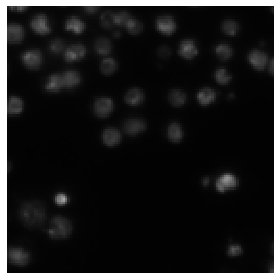

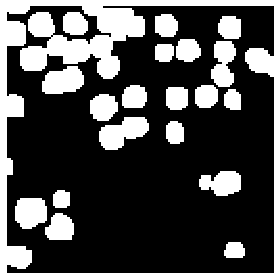

In [ ]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

# **UNET**

In [ ]:
num_classes = 1

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, "model.png")
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=128, epochs=25, callbacks=callbacks)

Epoch 1/25
28/28 [==============================] - 22s 67ms/step - loss: 0.5984 - accuracy: 0.7722 - val_loss: 0.6114 - val_accuracy: 0.8566
Epoch 2/25
28/28 [==============================] - 1s 39ms/step - loss: 0.3983 - accuracy: 0.8894 - val_loss: 0.4304 - val_accuracy: 0.8799
Epoch 3/25
28/28 [==============================] - 1s 40ms/step - loss: 0.2997 - accuracy: 0.9162 - val_loss: 0.3381 - val_accuracy: 0.8948
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.2486 - accuracy: 0.9312 - val_loss: 0.3919 - val_accuracy: 0.8669
Epoch 5/25
28/28 [==============================] - 1s 40ms/step - loss: 0.2089 - accuracy: 0.9401 - val_loss: 0.2309 - val_accuracy: 0.9296
Epoch 6/25
28/28 [==============================] - 1s 41ms/step - loss: 0.1827 - accuracy: 0.9471 - val_loss: 0.1641 - val_accuracy: 0.9544
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 0.1681 - accuracy: 0.9479 - val_loss: 0.1550 - val_accuracy: 0.9554
Epoch 8/25
2

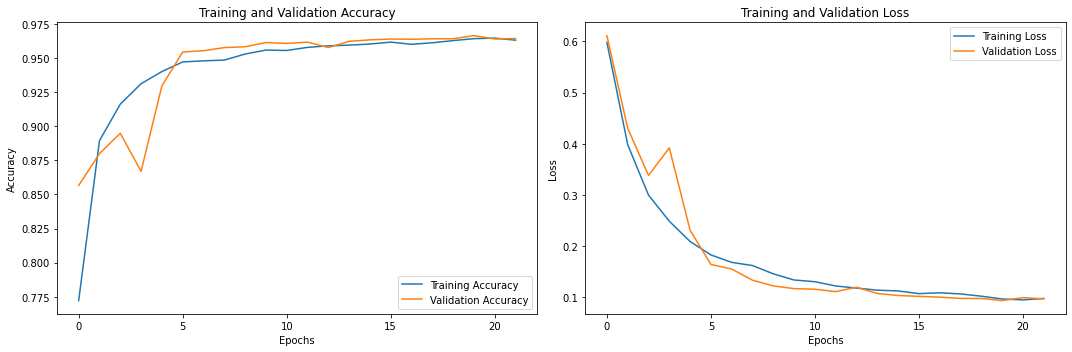

In [ ]:
import matplotlib.pyplot as plt

# get training and validation accuracy values from history object
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# get training and validation loss values from history object
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# plot accuracy values
axs[0].plot(train_acc, label='Training Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# plot loss values
axs[1].plot(train_loss, label='Training Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# adjust subplot layout and display plot
plt.tight_layout()
plt.savefig('plot1.png')
plt.show()

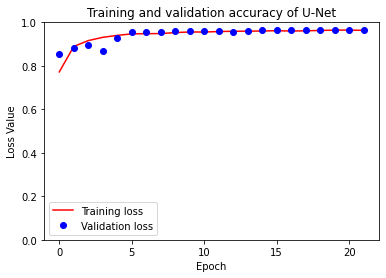

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training loss')
plt.plot( val_accuracy, 'bo', label='Validation loss')
plt.title('Training and validation accuracy of U-Net')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()
plt.savefig('plot2.png')

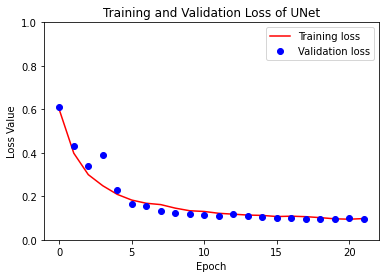

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss of UNet')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('plot1.png')
plt.show()

1/1 [==============================] - 0s 22ms/step


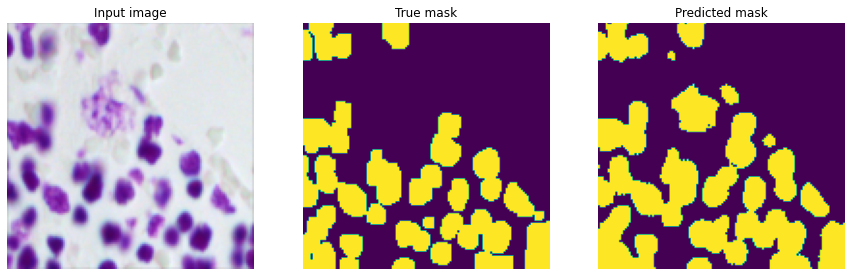

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.savefig('imgunet1.png')
  plt.show()
 
  
i = random.randint(0, len(X_test))
i=5
sample_image = X_test[i]
sample_mask = y_test[i]
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

In [ ]:
intersection = np.logical_and(sample_mask, predicted_mask)
union = np.logical_or(sample_mask, predicted_mask)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.81383907316299


In [ ]:
print(i)

207


In [ ]:
unet
1= 88  38
2=88 31
3= 84 26
4 =86 22
5= 81 22


66=84
160=73
33=93
207 83

In [ ]:
model.save('unet.h5')

In [ ]:
#model.save('my_model.h5')

# load the saved model
#loaded_model = load_model('my_model.h5')

## **LCRM-UNET**

In [ ]:
num_classes = 1

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=1,kernel_size=3,strides=(1,1),padding='same')(c1)
#c1= #tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=2,kernel_size=3,strides=(1,1),padding='same')(p1)
#c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=1,kernel_size=3,strides=(1,1),padding='same')(c2)
#c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=2,kernel_size=3,strides=(1,1),padding='same')(p2)
#c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)

c3 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=1,kernel_size=3,strides=(1,1),padding='same')(c3)
#c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c3 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=2,kernel_size=3,strides=(1,1),padding='same')(p2)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)

c4 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=1,kernel_size=3,strides=(1,1),padding='same')(c4)
#c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=2,kernel_size=3,strides=(1,1),padding='same')(p4)
#c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.DepthwiseConv2D(depth_multiplier=1,kernel_size=3,strides=(1,1),padding='same')(c5)
#c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model1, "model.png")

updated part


In [ ]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model1.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=50, callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 10s 67ms/step - loss: 0.6001 - accuracy: 0.7419 - val_loss: 0.6386 - val_accuracy: 0.8275
Epoch 2/50
28/28 [==============================] - 1s 39ms/step - loss: 0.3835 - accuracy: 0.8841 - val_loss: 0.5552 - val_accuracy: 0.8716
Epoch 3/50
28/28 [==============================] - 1s 39ms/step - loss: 0.2766 - accuracy: 0.9231 - val_loss: 0.5167 - val_accuracy: 0.8801
Epoch 4/50
28/28 [==============================] - 1s 41ms/step - loss: 0.2300 - accuracy: 0.9316 - val_loss: 0.4852 - val_accuracy: 0.8845
Epoch 5/50
28/28 [==============================] - 1s 39ms/step - loss: 0.1922 - accuracy: 0.9403 - val_loss: 0.4512 - val_accuracy: 0.8949
Epoch 6/50
28/28 [==============================] - 1s 39ms/step - loss: 0.1779 - accuracy: 0.9404 - val_loss: 0.4174 - val_accuracy: 0.8917
Epoch 7/50
28/28 [==============================] - 1s 41ms/step - loss: 0.1598 - accuracy: 0.9448 - val_loss: 0.3852 - val_accuracy: 0.9036
Epoch 8/50
2

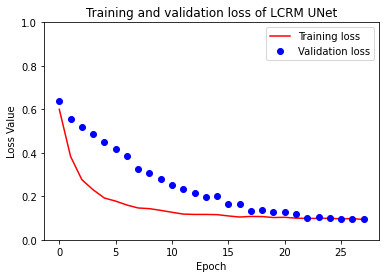

In [ ]:
loss = model1.history.history['loss']
val_loss = model1.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss of LCRM UNet')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('lcrmunetp1.png')
plt.show()

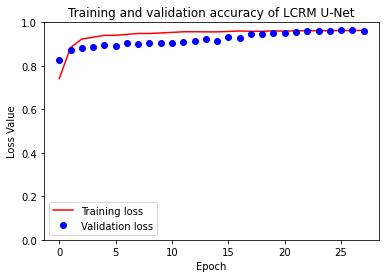

In [ ]:
accuracy = model1.history.history['accuracy']
val_accuracy = model1.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training loss')
plt.plot( val_accuracy, 'bo', label='Validation loss')
plt.title('Training and validation accuracy of LCRM U-Net')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('lcrmunetp2.png')
plt.show()


1/1 [==============================] - 0s 22ms/step


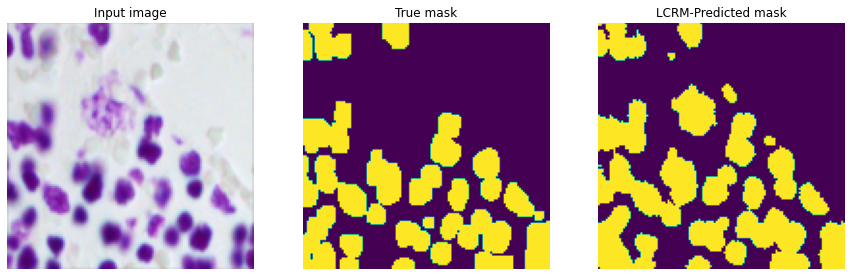

0.8063106796116505
5


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'LCRM-Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X_test))
i=5
sample_image = X_test[i]
sample_mask = y_test[i]
prediction = model1.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])


intersection = np.logical_and(sample_mask, predicted_mask)
union = np.logical_or(sample_mask, predicted_mask)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)
print(i)

In [ ]:
unet
1= 88  38
2=88 31
3= 84 26
4 =86 22
5= 81 22


66=84         83
160=73
33=93
207 83

In [ ]:

lcrm unet:       160 73
1 .82 23
2 89 23
3  80 22 
4 90 22
5 80.6 21

In [ ]:
model1.save('LCRMunet.h5')

In [ ]:
0.3 million -lc
1.4  unet


In [ ]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_10 (Dropout)           (None, 128, 128, 16  0           ['conv2d_14[0][0]']              
                                )                                                           

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             